In [ ]:
!nvidia-smi

Tue Apr 11 08:23:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install timm albumentations -q

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import ToTensor
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from timm import create_model

import shutil
import os
from pathlib import Path
import gc

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')

display(torch.__version__, torch.cuda.get_device_capability())

'2.0.0+cu118'

(8, 0)

In [ ]:
PATH = ''
shutil.unpack_archive(os.path.join(PATH, 'TreeImages.zip'), 'TreeImages')

In [ ]:
train = pd.read_csv(PATH + 'Train.csv')
test = pd.read_csv(PATH + 'Test.csv')
test['Target'] = 0
sample_submission = pd.read_csv(PATH + 'SampleSubmission.csv')

train['image_path'] = ['/content/TreeImages/'+ x for x in train.ImageId]
test['image_path'] = ['/content/TreeImages/'+ x for x in test.ImageId]

train.head()

,ImageId,Target,image_path
0,Id_jdqw9hlv6j.png,14.0,/content/TreeImages/Id_jdqw9hlv6j.png
1,Id_6xtrolmuvc.png,18.0,/content/TreeImages/Id_6xtrolmuvc.png
2,Id_2m49sj3xd9.png,0.0,/content/TreeImages/Id_2m49sj3xd9.png
3,Id_9jwg5pcnn4.png,28.0,/content/TreeImages/Id_9jwg5pcnn4.png
4,Id_vnm6e8n0p3.png,21.0,/content/TreeImages/Id_vnm6e8n0p3.png


In [ ]:
train.shape, test.shape

((2002, 3), (858, 3))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Config:
    SEED = 42
    N_SPLITS = 5
    MAX_EPOCHS = 70

    IMAGE_SIZE = 1024
    LEARNING_RATE = 5e-5
    DROPOUT = 0.5
    MODEL_NAME = 'convnext_large_384_in22ft1k'

    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 16
    NUM_WORKERS = os.cpu_count()
    N_TTA_AUGS = 10

    ID_COL = 'ImageId'
    LABEL_COL = 'Target'
    OUTPUT_PATH = './outputs'
    MODEL_SAVE_PATH = './model_checkpoints'

In [ ]:
Path(Config.OUTPUT_PATH).mkdir(parents=True, exist_ok=True)
Path(Config.MODEL_SAVE_PATH).mkdir(parents=True, exist_ok=True)

In [ ]:
def seed_all(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)  
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  
    np.random.seed(seed)  
    random.seed(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

seed_all(Config.SEED)

In [ ]:
train_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.LongestMaxSize(p = 0.1),
        A.VerticalFlip(p=0.5),
        A.SmallestMaxSize(p = 0.1),
        A.Resize(height=Config.IMAGE_SIZE, width=Config.IMAGE_SIZE, always_apply=True),
        A.Normalize(always_apply=True),
        ToTensorV2(always_apply=True),  
])

val_transforms = A.Compose([
    A.Resize(height=Config.IMAGE_SIZE, width=Config.IMAGE_SIZE, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(),
])

tta_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.LongestMaxSize(p = 0.1),
    A.VerticalFlip(p=0.5),
    A.SmallestMaxSize(p = 0.1),
    
    A.Resize(height=Config.IMAGE_SIZE, width=Config.IMAGE_SIZE, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(),
])

In [ ]:
class PalmTreesDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.image_names = self.df["ImageId"].values
        self.image_paths = self.df["image_path"].values
        self.targets = self.df["Target"].values
        self.augmentations = augmentations

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = self.image_paths[idx]
        image = np.array(Image.open(image_path))

        if self.augmentations is not None:
            augmented_image = self.augmentations(image=image)
            image = augmented_image['image']

        target = self.targets[idx]
        target = torch.tensor(target, dtype=torch.float)
        return {"ImageId": image_name, "image": image, "target": target}

In [ ]:
def create_dataloader(df, transforms, batch_size, shuffle, seed=0):
  def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

  g = torch.Generator()
  if seed == 0:
    g.manual_seed(Config.SEED)
  else:
    g.manual_seed(seed)
  df_dataset = PalmTreesDataset(df, transforms)
  df_loader = DataLoader(df_dataset, batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=os.cpu_count(),
                          worker_init_fn=seed_worker,
                          generator=g,)
  return df_loader

In [ ]:
train_loader = create_dataloader(train, train_transforms, Config.TRAIN_BATCH_SIZE, True)

batch = next(iter(train_loader))
images, targets = batch['image'], batch['target']
images.shape, targets.shape

(torch.Size([8, 3, 1024, 1024]), torch.Size([8]))

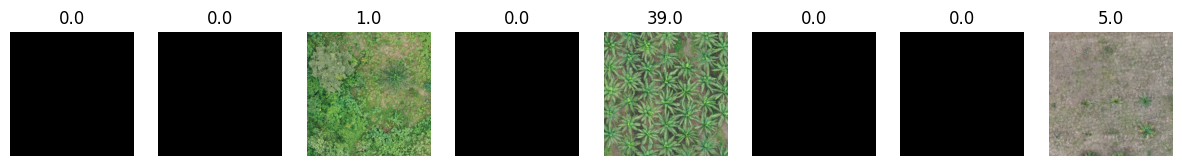

In [ ]:
fig = plt.figure(figsize = (15,8))
rows, cols = 4, 8
std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])
for i in range(len(images)):
  if i > rows*cols-1:
    break
  else:
    image, target = images[i], targets[i]
    fig.add_subplot(rows, cols, i+1)
    img = ((image.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.imshow(img)
    plt.title(target.item())
    plt.axis(False)

In [ ]:
class PalmTreeModel(nn.Module):
  def __init__(self, model_name, pretrained=True, num_classes=0, in_channels=3):
    super().__init__()
    self.backbone = create_model(model_name, pretrained=pretrained, num_classes=num_classes, in_chans=in_channels)
    in_features = self.backbone.num_features
    self.fc = nn.Sequential(nn.Dropout(Config.DROPOUT), nn.Linear(in_features, 1), nn.ReLU())

  def forward(self, x):
    f = self.backbone(x)
    out = self.fc(f).squeeze(1)
    return out

In [ ]:
def train_step(model, dataloader, loss_fn,optimizer, scheduler, scaler):
  model.train()
  train_loss = 0
  for batch in dataloader:
    images, targets = batch['image'].to(device), batch['target'].to(device)

    with torch.cuda.amp.autocast():
      y_pred = model(images).squeeze()
      loss = loss_fn(y_pred, targets)
      train_loss += loss.item() 

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    scheduler.step()

  train_loss = train_loss / len(dataloader)
  return np.sqrt(train_loss)

def test_step(model, dataloader, loss_fn):
  model.eval() 
  test_loss = 0
  with torch.no_grad():
    for batch in dataloader:
      images, targets = batch['image'].to(device), batch['target'].to(device)
      test_pred_logits = model(images).squeeze()
      loss = loss_fn(test_pred_logits, targets)
      test_loss += loss.item()
          
  test_loss = test_loss / len(dataloader)
  return np.sqrt(test_loss)

In [ ]:
class SaveBestModel:
  def __init__(self, best_valid_loss=float('inf')):
    self.best_valid_loss = best_valid_loss
      
  def __call__(self, current_valid_loss, epoch, model, optimizer, criterion, fold):
    if current_valid_loss < self.best_valid_loss:
      self.best_valid_loss = current_valid_loss
      print(f"---------------BestLoss: {self.best_valid_loss: .4f} Epoch: {epoch}------------")
      dir_path = Config.MODEL_SAVE_PATH+os.sep+str(fold)
      Path(dir_path).mkdir(parents=True, exist_ok = True)
      best_model_path = os.path.join(dir_path, 'best_model.pth')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': criterion,
          'best_loss': self.best_valid_loss
          }, best_model_path)

In [ ]:
def train_model(model, train_dataloader, val_dataloader,
                scheduler, optimizer,scaler, loss_fn,
                save_best_model,
                fold=0,
                epochs= 5):
  results = {"train_loss": [], "test_loss": []}

  for epoch in range(epochs):
    train_loss = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            scheduler = scheduler,
                            scaler = scaler)
    test_loss = test_step(model=model,dataloader=val_dataloader,loss_fn=loss_fn)   
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} TrainLoss: {train_loss:.4f} TestLoss: {test_loss:.4f}")
    save_best_model(test_loss, epoch, model, optimizer, loss_fn, fold)
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
  return results

def make_prediction(path, test_loader):
  loaded_model = PalmTreeModel(Config.MODEL_NAME)
  loaded_model = torch.compile(loaded_model).to(device)
  model_dict = torch.load(path)
  best_loss, epoch = model_dict['best_loss'], model_dict['epoch']
  loaded_model.load_state_dict(model_dict['model_state_dict'])

  preds, image_ids = [], []
  with torch.no_grad():
    loaded_model.eval()
    for batch in test_loader:
      image, image_id = batch['image'].to(device), batch['ImageId']
      pred = loaded_model(image)
      preds.extend(pred.detach().cpu().numpy())
      image_ids.extend(image_id)

  preds_df = pd.DataFrame(preds)
  preds_df.insert(0, Config.ID_COL, image_ids)
  preds_df.columns = [Config.ID_COL, Config.LABEL_COL]

  del loaded_model, test_loader
  gc.collect()
  torch.cuda.empty_cache()
  gc.collect()
  return preds_df

def save_predictions(best_model_path, fold):
  test_loader = create_dataloader(test, val_transforms, Config.VAL_BATCH_SIZE, False)
  vanilla_pred_df = make_prediction(best_model_path, test_loader)

  random.seed(Config.SEED)
  tta_predictions = {}
  seeds = random.sample(range(1, Config.SEED*999), Config.N_TTA_AUGS)
  for seed in seeds:
    test_loader = create_dataloader(test, tta_transforms, Config.VAL_BATCH_SIZE, False, seed)
    preds_df = make_prediction(best_model_path, test_loader)
    tta_predictions[seed] = preds_df

  tta_pred_df = sample_submission.copy()
  tta_pred_df.Target = np.mean([tta_predictions[seed].Target for seed in seeds], 0)

  dir_path = Config.OUTPUT_PATH+os.sep+str(fold)
  Path(dir_path).mkdir(parents=True, exist_ok = True)

  vanilla_pred_df.to_csv(os.path.join(dir_path, f'F{fold}_vanilla.csv'), index = False)
  tta_pred_df.to_csv(os.path.join(dir_path, f'F{fold}_tta.csv'), index = False)

  _ = [tta_predictions[seed].to_csv(os.path.join(dir_path, f'F{fold}_S_{seed}_tta.csv'), index = False) for seed in tta_predictions.keys()]
  return vanilla_pred_df, tta_pred_df, tta_predictions

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_1k_384.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_1k_384.pth
[2023-04-11 08:26:40,744] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-04-11 08:30:09,973] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 0 TrainLoss: 8.1247 TestLoss: 5.9865
---------------BestLoss:  5.9865 Epoch: 0------------
---------------BestLoss:  4.5302 Epoch: 1------------
---------------BestLoss:  3.9203 Epoch: 2------------
---------------BestLoss:  3.2609 Epoch: 3------------
---------------BestLoss:  3.0874 Epoch: 4------------
---------------BestLoss:  2.7983 Epoch: 5------------
---------------BestLoss:  2.7920 Epoch: 6------------
---------------BestLoss:  2.5477 Epoch: 8------------
Epoch: 10 TrainLoss: 2.2767 TestLoss: 2.5834
---------------BestLoss:  2.5187 Epoch: 11------------
---------------BestLoss:  2.3898 Epoch: 13------------
---------------BestLoss:  2.3325 Epoch: 14------------
---------------BestLoss:  2.3216 Epoch: 16------------
---------------BestLoss:  2.2521 Epoch: 19------------
Epoch: 20 TrainLoss: 1.5180 TestLoss: 2.4323
---------------BestLoss:  2.2261 Epoch: 22------------
---------------BestLoss:  2.1958 Epoch: 24------------
Epoch: 30 TrainLoss: 1.2495 TestLoss: 2.2314
----

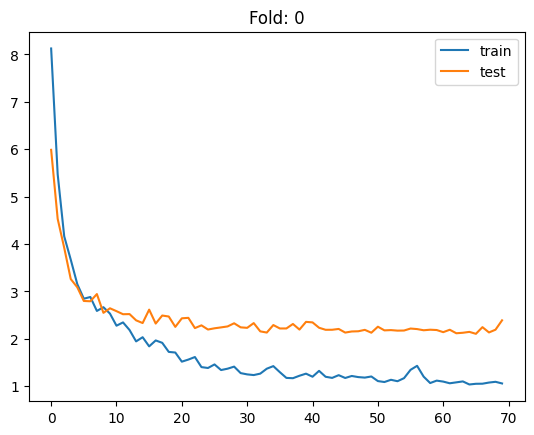

CPU times: user 3h 50min 44s, sys: 9min 13s, total: 3h 59min 57s
Wall time: 4h 3min 16s


In [ ]:
%%time
train['fold'] = 0 
skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=Config.SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(train.image_path, train.Target)):
  train.loc[val_idx, 'fold'] = fold

vanilla_preds, tta_preds, tta_preds_dicts = [], [], []
for fold in range(1):
  seed_all(seed=Config.SEED)
  train_fold = train[train.fold != fold].reset_index(drop = True)
  val_fold = train[train.fold == fold].reset_index(drop = True)

  train_loader = create_dataloader(train_fold, train_transforms, Config.TRAIN_BATCH_SIZE, True)
  val_loader = create_dataloader(val_fold, val_transforms, Config.VAL_BATCH_SIZE, False)

  model = PalmTreeModel(Config.MODEL_NAME)
  model = torch.compile(model, backend="inductor").to(device)
  torch._dynamo.config.suppress_errors = True

  loss_fn = nn.MSELoss().to(device)
  optimizer = torch.optim.AdamW(params=model.parameters(), lr = Config.LEARNING_RATE)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=160, eta_min=1e-5)
  scaler = torch.cuda.amp.GradScaler()
  save_best_model = SaveBestModel()

  model_results = train_model(model=model, 
                          train_dataloader=train_loader,
                          val_dataloader=val_loader,
                          optimizer=optimizer,
                          scheduler=scheduler,
                          scaler=scaler,
                          save_best_model = save_best_model,
                          fold = fold,
                          loss_fn=loss_fn, 
                          epochs=Config.MAX_EPOCHS)
  
  dir_path  = Config.MODEL_SAVE_PATH+os.sep+str(fold)
  best_model_path = os.path.join(dir_path, 'best_model.pth')

  vanilla_pred_df, tta_pred_df, tta_pred_dict = save_predictions(best_model_path, fold)
  vanilla_preds.append(vanilla_pred_df)
  tta_preds.append(tta_pred_df)
  tta_preds_dicts.append(tta_pred_dict)

  plt.plot(range(Config.MAX_EPOCHS), model_results['train_loss'], label = 'train')
  plt.plot(range(Config.MAX_EPOCHS), model_results['test_loss'], label = 'test')
  plt.title(f'Fold: {fold}')
  plt.legend()
  plt.show()

In [ ]:
final_sub = tta_preds_dicts[0][1640].copy()
final_sub.to_csv('final_sub.csv', index = False)